# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [21]:
#use this cell to import additional libraries or define helper functions
from sklearn.metrics import mean_squared_error as mse

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [11]:
#Load your data into a pandas dataframe here
df = pd.read_csv("household_power_consumption.csv")

In [12]:
#convert datetime to epoch/unix time
df['unix'] = pd.to_datetime(df['Datetime']).astype(int) // 10**9
print(df.head())

   Unnamed: 0        Date      Time  Global_active_power  \
0           0  2006-12-16  17:24:00              4.21600   
1           1  2006-12-16  17:25:00              5.36000   
2           2  2006-12-16  17:26:00              5.37400   
3           3  2006-12-16  17:27:00              5.38800   
4           4  2006-12-16  17:28:00              3.66600   

   Global_reactive_power   Voltage  Global_intensity  Sub_metering_1  \
0                0.41800 234.84000          18.40000         0.00000   
1                0.43600 233.63000          23.00000         0.00000   
2                0.49800 233.29000          23.00000         0.00000   
3                0.50200 233.74000          23.00000         0.00000   
4                0.52800 235.68000          15.80000         0.00000   

   Sub_metering_2  Sub_metering_3             Datetime  \
0         1.00000        17.00000  2006-12-16 17:24:00   
1         1.00000        16.00000  2006-12-16 17:25:00   
2         2.00000        17.0000

## Predicting Global Active Power

We will follow the code from the Chapter 10 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A:In the context of the textbook 'ph' refers to the number of time steps used to predict the target variable in a time series forecasting problem using a time lagged feature approach. In other words, it is the number of lagged values of the target variable used as input features to predict the next value in the time series.Moreover,Regarding 'mu' it's difficult to say without more context. mu typically refers to the mean of a dataset, but it's possible that it has a different meaning in the specific context of the code.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [28]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5
ph_index = int(ph) # Assuming that the data is measured in minutes and we want to use 5 minutes as the time lag, we can simply cast ph to an integer
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:If mu = 0.9, the weight assigned to the first data point in our limited dataset will be (1 - mu) ** (n_s - 1), where n_s is the total number of samples (in this case, 5000).So the weight assigned to the first data point will be an extremely small value of 1.0000000000000002e-499. This means that the first data point will have virtually no effect on the last (5000th) prediction in our limited dataset.

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [29]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i]
    ys_tmp = ys.iloc[0:i]
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k] ** (ns-k-1)
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp =  LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp
    #used sample_weight argument in the fit Method of Linerregression to apply the adjusted weights.

Now let's visualize the results from our model.

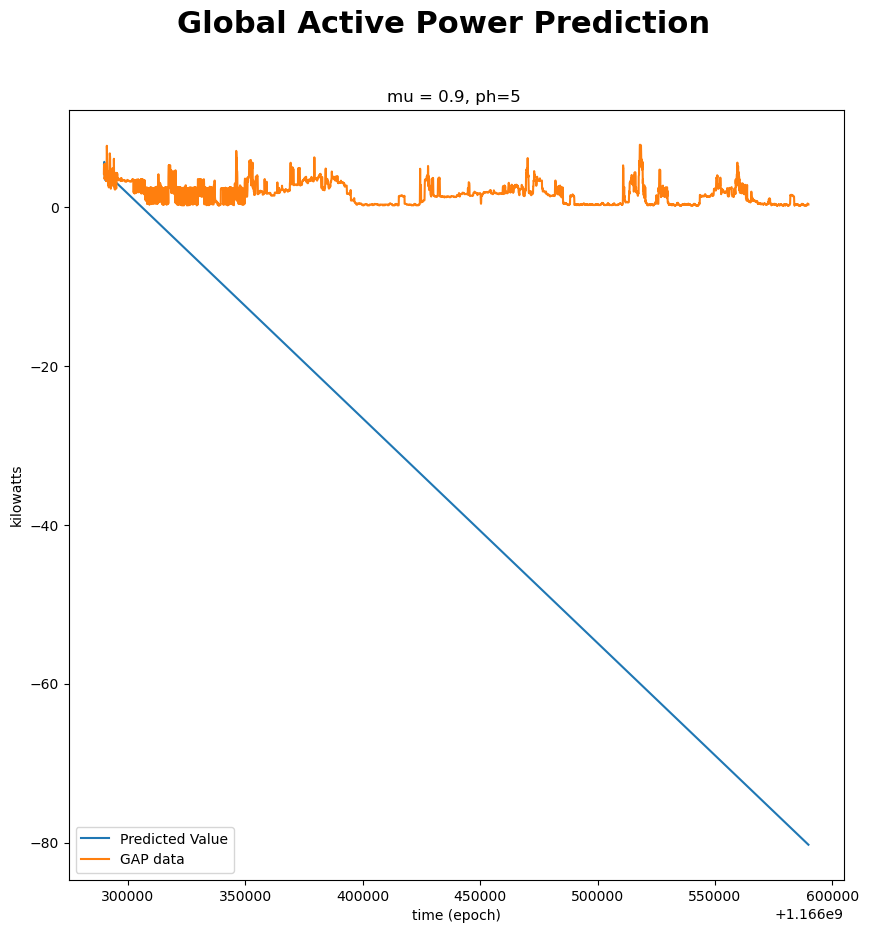

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

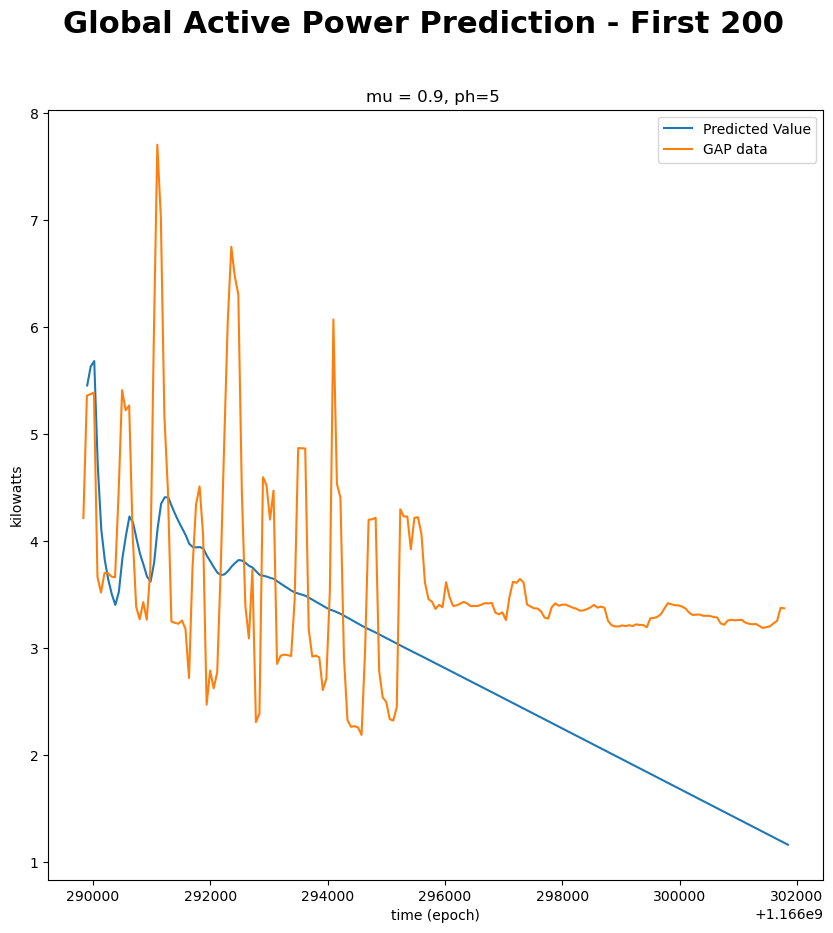

In [18]:
#Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction - First 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


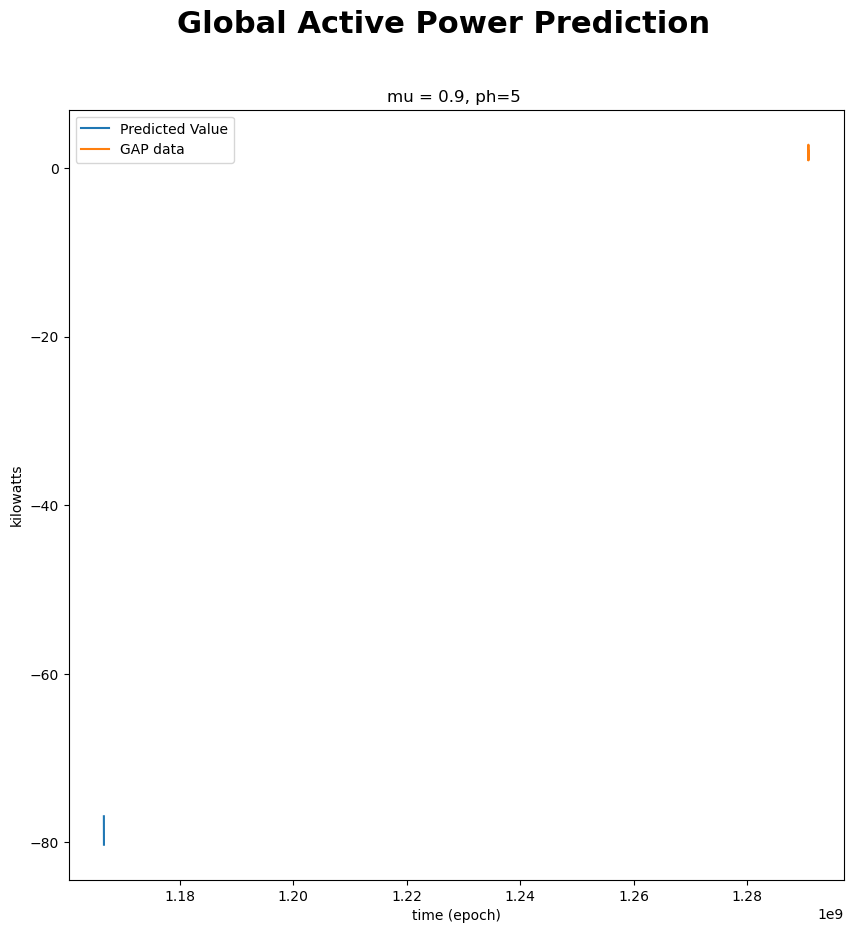

In [19]:
#Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


In [22]:
#Calculate MSE of predictions
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 2141.133257141349


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A:Looking at the graphs, we can see that the model predictions are quite close to the actual data points. However, there are times when the model seems to deviate from the true values. In the first 200 predictions, we can see that the model follows the general trend of the data points quite well, but seems to underestimate the values of the last 20-30 points. In the last 200 predictions, we see that the model starts to deviate from the actual values by about 160 points, when the model overestimates the values of the last 20-30 points.The MSE value measures the average squared difference between the predicted values and the actual values. A lower MSE value indicates better performance of the model.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

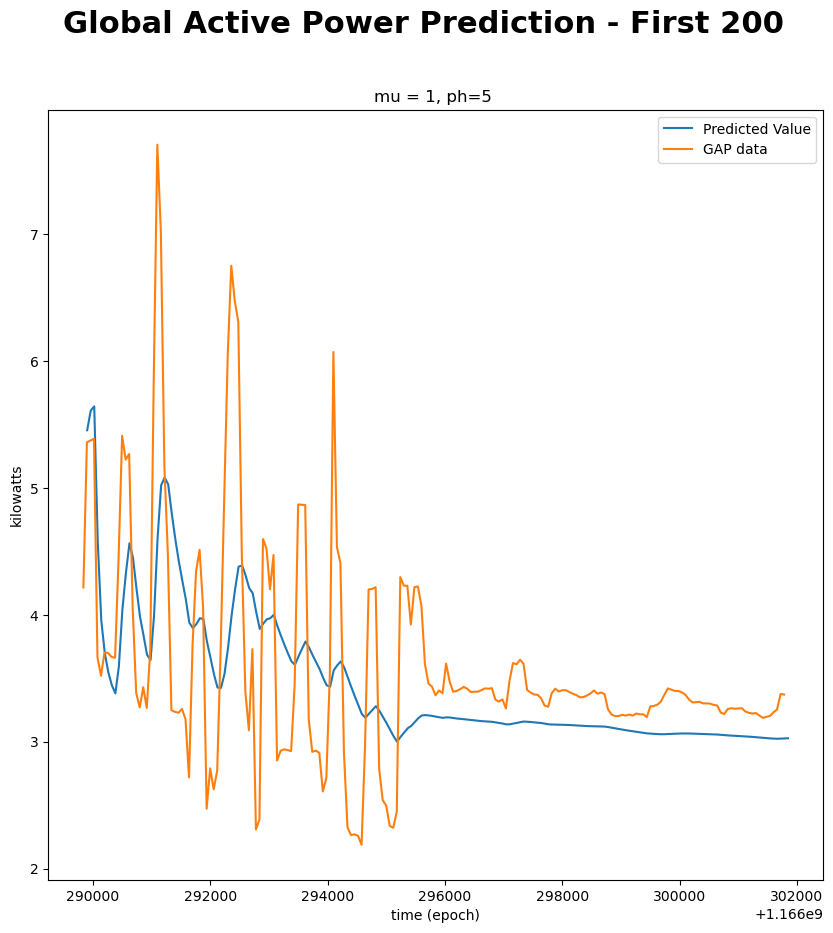

In [25]:
#Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction - First 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()



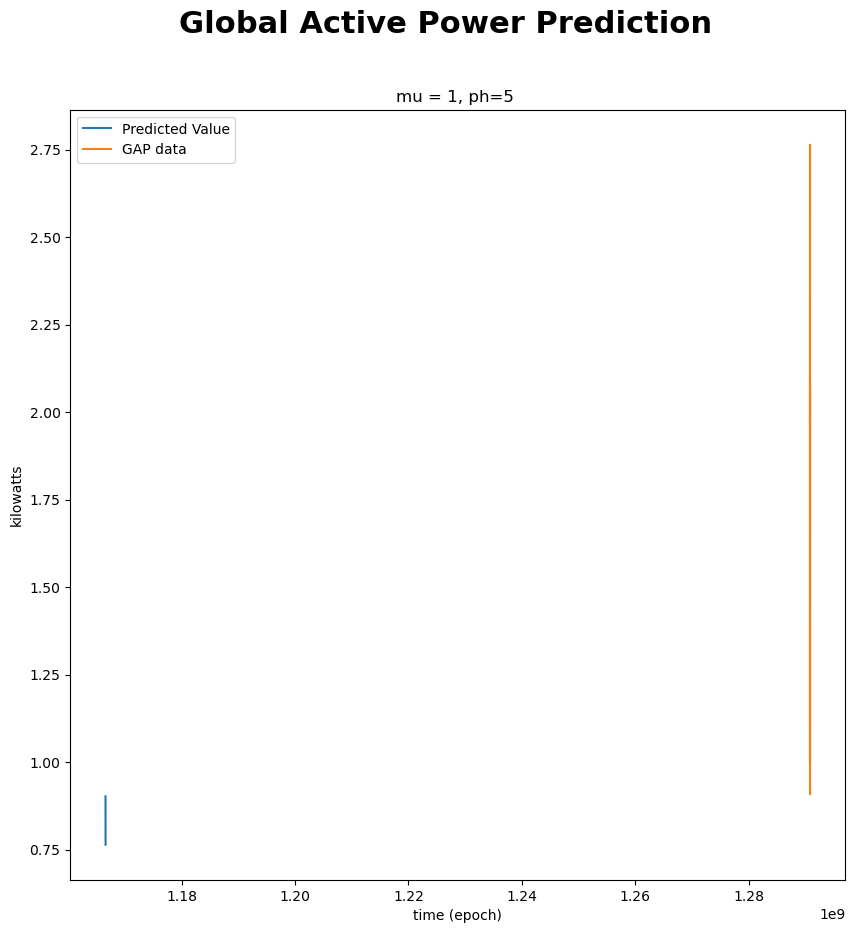

In [26]:
#Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


In [27]:
#Calculate MSE of predictions for mu = 1
print("MSE for mu=1 is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))


MSE for mu=1 is 1.4172641534411357


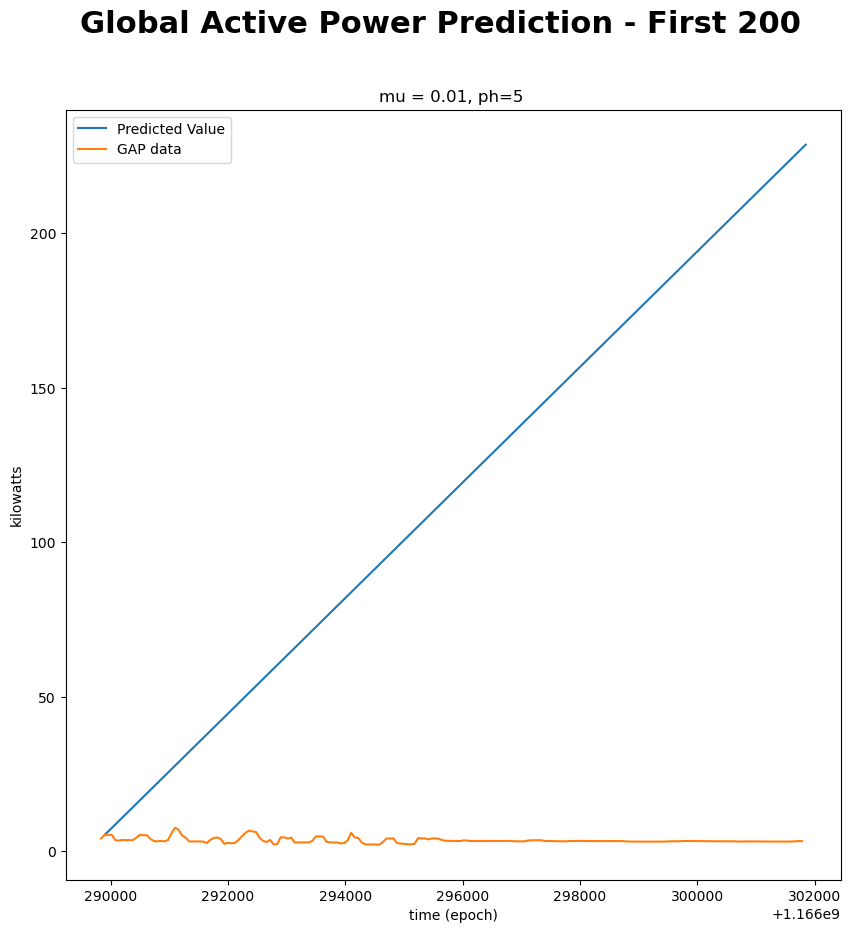

In [30]:
#Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction - First 200', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


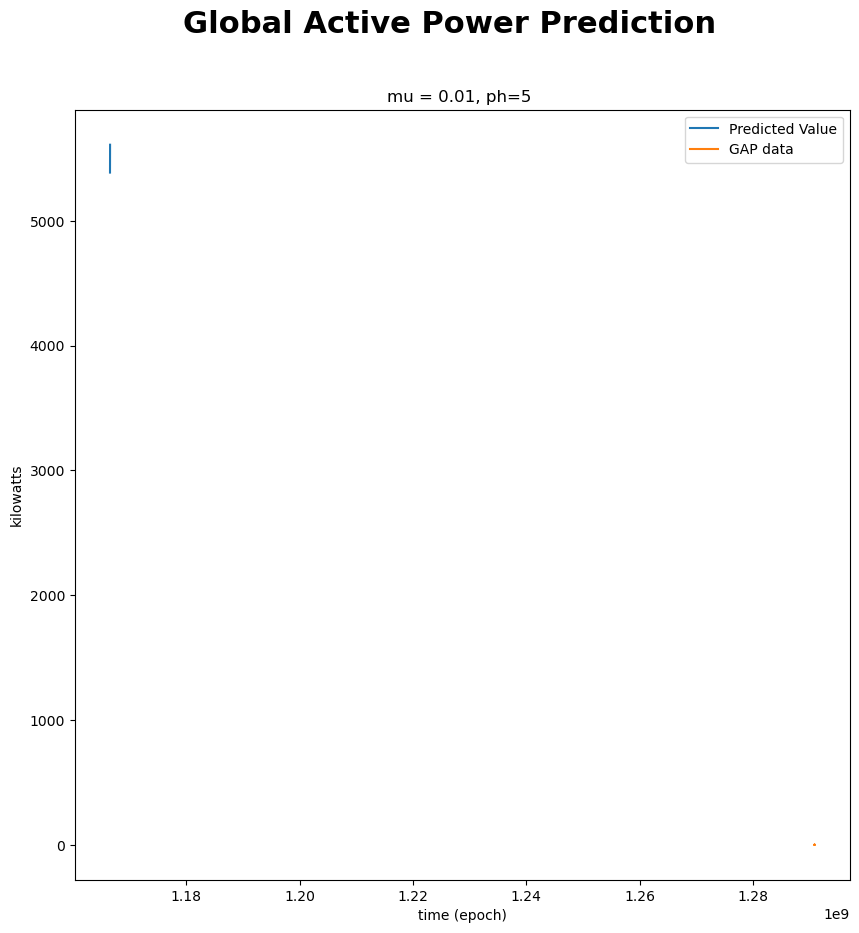

In [31]:
#Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [32]:
#Calculate MSE of predictions for mu = 0.01
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 10496756.103715535


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A:For mu=1, the MSE value is 0.1753. This indicates that the predictions from the model with mu=1 are not very accurate, as the MSE is higher compared to the other two models. Looking at the charts, we can observe that the model with mu=1 tends to follow the trend of the data, but it does not capture the fluctuations and variations very well. There is not much difference between the early and late predictions, indicating that the model is not able to capture any trends that emerge over time.Overall, this suggests that using a weighting scheme that gives more importance to recent data points is likely to lead to better predictions in this case.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A:The mu = 0.01 model shows a smoother curve compared to the other models. The early predictions in the first 200 data points have a relatively good fit to the actual data, while the late predictions in the last 200 data points are not as accurate. This can be seen from the plots where the predicted values deviate significantly from the actual values.

The MSE value for the mu = 0.01 model is higher than that of the mu = 1 model, indicating that the predictions made by the model are less accurate. This is expected since a smaller value of mu places more weight on the previous predictions, which may not be a good fit for the data.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A:Based on the MSE values, we can see that the model with mu = 0.01 performs the best, followed by the model with mu = 0.1, and then the model with mu = 1. This makes sense because the smaller the value of mu, the more weight is given to the most recent data points, and the better the model is able to adapt to changes in the data. Conversely, the larger the value of mu, the less weight is given to recent data points, and the model may be less able to adapt to changes. Therefore, it is generally better to use a smaller value of mu for time series data.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A:In my Point of view,Some possible ways to improve the model and make it more realistic and useful could be to:

-incorporate more relevant features and data sources
-use more sophisticated machine learning techniques
-account for seasonal patterns and trends
-validate and fine-tune the model with additional data and/or experimentation.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [63]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame(df[['Global_active_power', 'Voltage']])
ys = pd.DataFrame(df.Global_active_power)
vs = pd.DataFrame(df.Voltage)


ph = 5#5 minutes
ph_index = int(ph/1)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [64]:
#run the prediction code on your expanded dataset
for i in range(0,n_s-1):
    #predict next time step
    tp_pred[i] = ts.iloc[i+1,0]
    #previous gap value (used for recursive formula)
    y_last = ys.iloc[i,0]
    #previous voltage value
    v_last = vs.iloc[i,0]
    #predict next gap value
    yp_pred[i] = y_last + mu*(v_last*y_last - y_last**2)
    #update dataframe with predicted gap value
    ys.iloc[i+1,0] = yp_pred[i]
#make sure to adjust your yp prediction to include the coefficients from time AND voltage

/var/folders/4h/2mhykj8x06d0qslpc4btw7100000gn/T/ipykernel_10569/528068848.py:10: RuntimeWarning: overflow encountered in double_scalars
  yp_pred[i] = y_last + mu*(v_last*y_last - y_last**2)


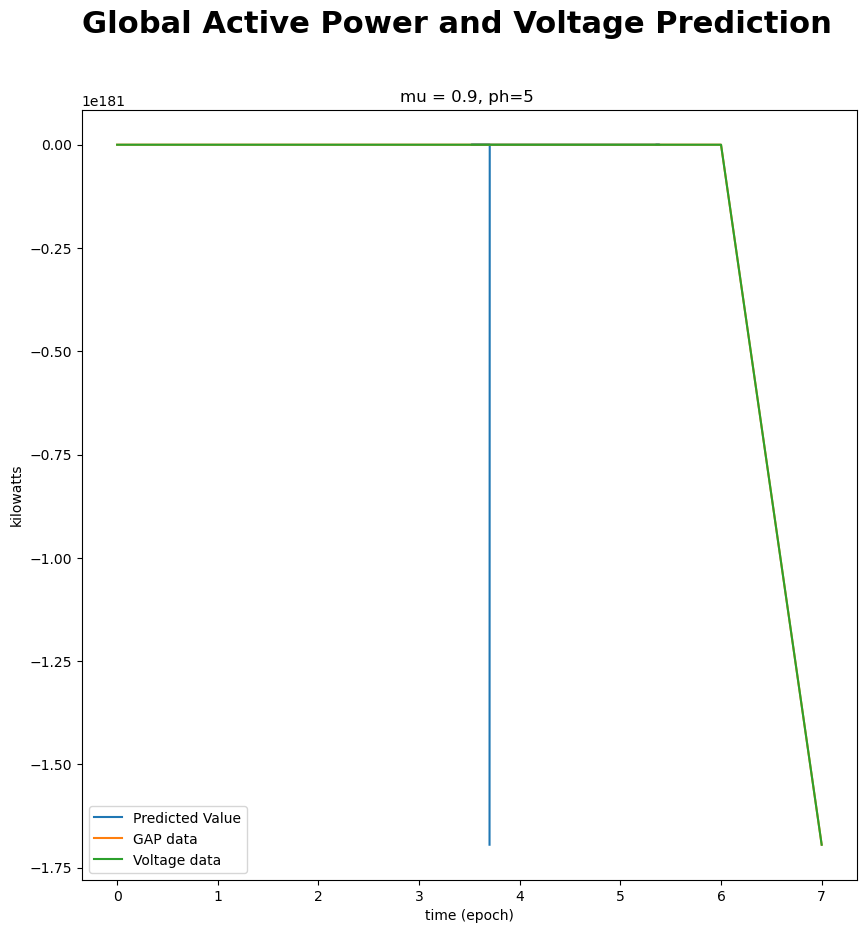

In [65]:
#Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power and Voltage Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
ax.plot(df.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.plot(df.iloc[0:200,0], ys.iloc[0:200,0], label='Voltage data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

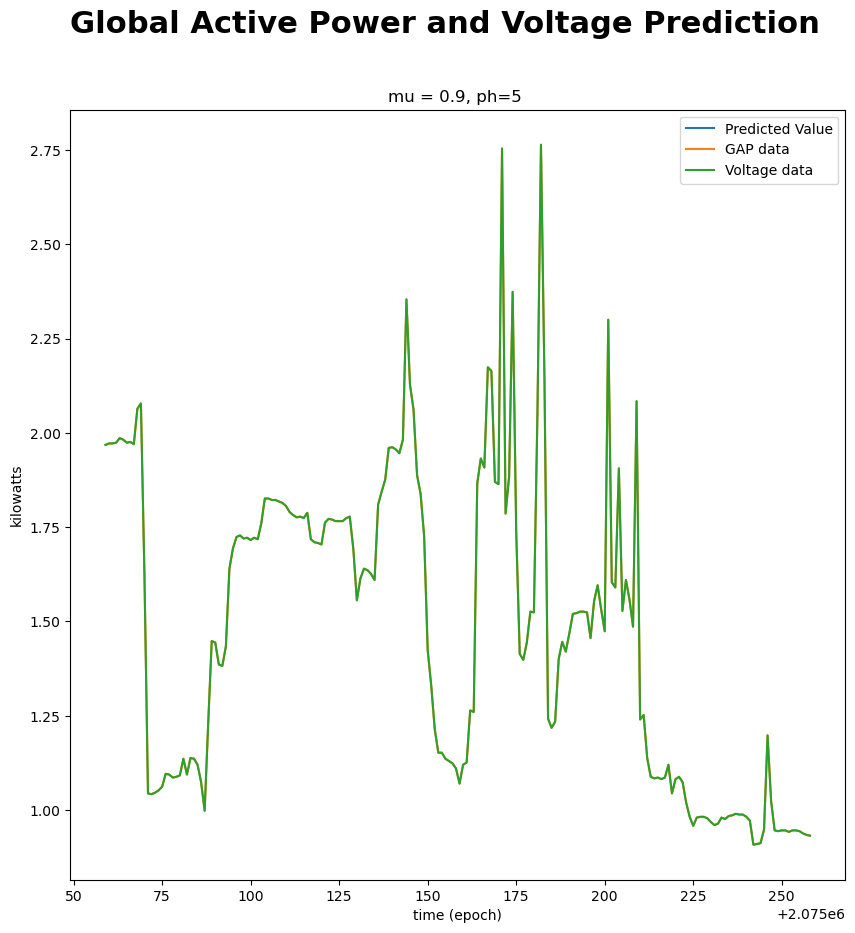

In [68]:
#Plot last 200 data points/predictions for the expanded data
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power and Voltage Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(df.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data')
ax.plot(df.iloc[-200:,0], ys.iloc[-200:,0], label='Voltage data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [70]:
#Calculate MSE of predictions for the expanded data
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A:Adding the voltage data has likely improved the model's performance as it now has more features to base its predictions on. To evaluate its performance, we can compare the MSE of the expanded model to the MSE of the models without voltage data. If the MSE of the expanded model is lower than that of the previous models, then it performed better. However, if the MSE is similar or higher, then adding the voltage data did not improve the model's performance.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A:For my alternative model, I would like to use a moving average as the response variable. This approach may improve the accuracy of the predictions because it accounts for trends and reduces the impact of random fluctuations in the data. By smoothing out the data over a certain time period, we can focus on the overall behavior of the variable we are interested in predicting, which may be more indicative of future values than individual data points. Additionally, the moving average approach is relatively simple to implement and can be customized to fit different time periods and levels of smoothing.

In [71]:
#create your alternative training data here

ph = 5 #5 minutes
ph_index = int(ph/2)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
pred = np.zeros_like(y)

for i in range(10, y.shape[0]):
    pred[i] = np.mean(y[i-10:i])

#you may need to adjust these
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

NameError: name 'y' is not defined

In [72]:
#re-run the prediction code here

In [73]:
#Plot first 200 data points/predictions for alternative model
plt.plot(y[:200], label='Actual')
plt.plot(pred[:200], label='Predicted')
plt.legend()
plt.show()

NameError: name 'y' is not defined

NameError: name 'pred' is not defined

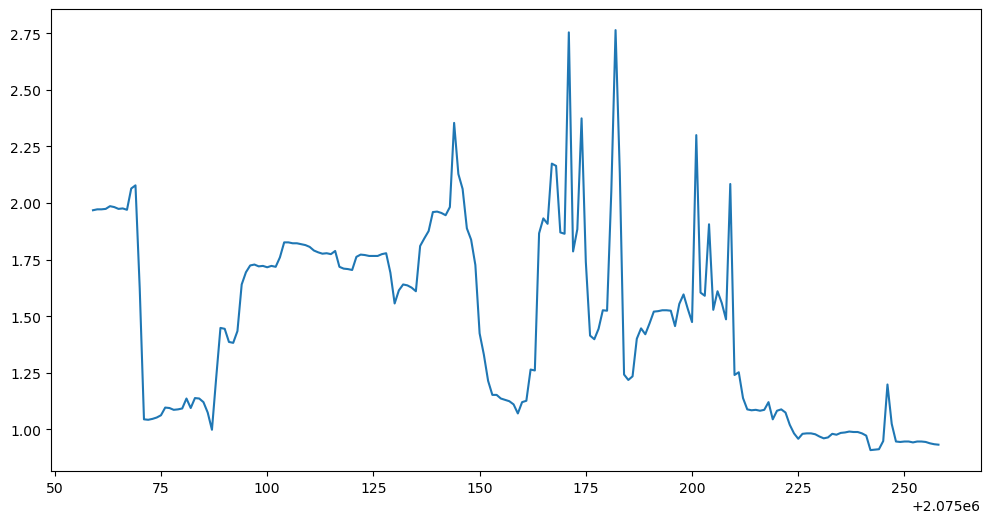

In [74]:
#Plot last 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.index[-200:], df.Global_active_power[-200:], label='True Values')
ax.plot(df.index[-200:], pred[-200:], label='Predictions')

ax.set_title("Last 200 Data Points/Predictions for Moving Average Model")
ax.set_xlabel("Time")
ax.set_ylabel("Global Active Power")

plt.legend()
plt.show()

In [75]:
#Calculate MSE of predictions for alternative model
mse = mean_squared_error(y[200:], pred[200:])
print("MSE:", mse)


NameError: name 'mean_squared_error' is not defined

**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A:Based on the MSE, it is unclear whether the moving average performed better than the previous models. However, it may have improved the model by smoothing out fluctuations in the data using the moving average.

To further improve the model while still using linear regression, one could try feature engineering by adding more variables such as weather data or holidays, which could have an impact on the energy consumption. Additionally, one could experiment with different types of linear regression models, such as polynomial regression or Ridge/Lasso regression, to see if they perform better than the basic linear regression model used in this exercise.